_____

<table align="left" width=100%>
    <td>
        <div style="text-align: center;">
          <img src="./images/bar.png" alt="entidades financiadoras"/>
        </div>
    </td>
    <td>
        <p style="text-align: center; font-size:24px;"><b>Introduction to Data Science</b></p>
        <p style="text-align: center; font-size:18px;"><b>Master in Electrical and Computer Engineering</b></p>
        <p style="text-align: center; font-size:14px;"><b>Pedro Cardoso (pcardoso@ualg.pt)</b></p>
    </td>
</table>

_____

# Outliers and anomaly detection on TS

Event detection in time series involves identifying significant changes or anomalies in the data that could be indicative of important events or patterns. There are several methods and techniques for event detection in time series, and the choice of method depends on the specific application and characteristics of the data.

In this context, __outliers__ and __anomalies__ are often used interchangeably, but they are not exactly the same thing in the context of time series data.

- An __outlier is a data point that is significantly different from the other data points in a dataset__. Outliers can be caused by measurement errors, data processing errors, or legitimate extreme events in the data. Outliers can be identified using statistical methods such as the Z-score method, the modified Z-score method, or the box plot method.

- An __anomaly__, on the other hand, __is a pattern in the data that deviates significantly from the expected pattern__. Anomalies can be caused by unusual events or changes in the underlying process that generates the data. Anomalies can be identified using time series analysis methods such as trend analysis, seasonality analysis, or time series decomposition.

In other words, an outlier is a single data point that stands out from the rest of the data, while an anomaly is a pattern in the data that stands out from the expected pattern. Outliers may or may not be anomalies, depending on the context of the data and the analysis being performed.

It's worth noting that the terms "__outlier__" and "__anomaly__" are sometimes used interchangeably, and different fields and applications may have different definitions and interpretations of these terms. In general, the goal of identifying outliers and anomalies is to detect unusual or unexpected events in the data, which may require further investigation or action.

Further, in this context, __events__ are occurrences that are of interest to the analyst or user. They can be planned events, such as a product launch or a holiday, or unplanned events, such as a natural disaster or a terrorist attack. Events can be identified based on a specific date or time, and they can be used to explain changes or anomalies in the time series data. Events can also be used to forecast future values of the time series data based on past occurrences of similar events.

So, some common approaches to anomaly/event/outlier detection in time series are:

- **Statistical methods**: Statistical methods involve analyzing the statistical properties of time series data to identify anomalies.

- **Machine learning methods**: Machine learning methods involve training models on historical time series data to learn patterns and anomalies. These methods can be used for both supervised and unsupervised learning.

- **Time series decomposition methods**: Time series decomposition methods involve breaking down a time series into its components, such as trend, seasonality, and residual noise. Anomalies can then be identified as data points that deviate from the expected pattern in one or more of these components.

## Statistical methods

This section presents some statistical methods for anomaly/event/outlier detection. To illustrate these methods, we will use the following time series data, which represents the electricity consumption of a house. Data can be found in the file `house_consumption.csv` in the `data/house_consumption_TS` folder. The data is sampled every 15 minutes but we will resample it to 6 hour and focus on the months from September to December 2022 to simplify the analysis.

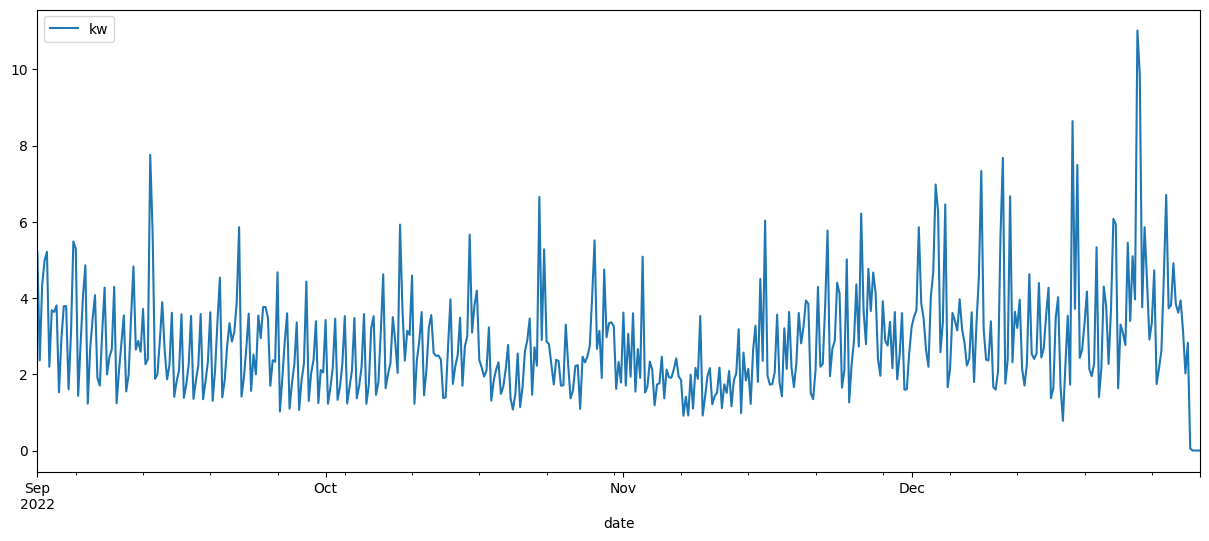

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib widget # use this to allow to interact with the plots

# load data
df = pd.read_csv('./data/house_consumption_TS/house_consumption.csv')
df.date = pd.to_datetime(df.date)

# set the index to be the date and resample to 6h consumption
df.set_index('date', inplace=True)
df = df.resample('6h').sum()/4

# filter data to have only the months from september to December 2022 records
query = (df.index >= '2022-09-01') & (df.index <= '2022-12-31')
df = df[query]

# visualize the data
df.plot(figsize=(15, 6))
plt.show()

Another relevant aspect is the  fact that the data has a normal distribution. This is important because many statistical methods for anomaly detection assume that the data is normally distributed. 

<Axes: >

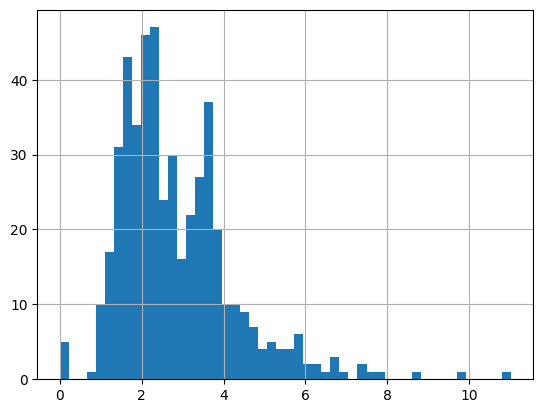

In [2]:
df.kw.hist(bins=50)

As we can see, the data is not exactly normally distributed, but it is close enough to apply some of the statistical methods for anomaly detection. Let us start by applying the Z-score method.

### Z-score method
The **Z-score method** identifies data points that are more than a certain number of standard deviations away from the mean. Typically, data points with Z-scores greater than 3 or less than -3 are considered anomalies.

To apply the Z-score method to a time series, you can follow these steps:

1. Compute the mean and standard deviation of the time series data.

2. Calculate the Z-score for each data point in the time series using the formula:
$$Z = \frac{x - \mu}{\sigma},$$
where $x$ is the data point, $\mu$ is the mean of the time series, and $\sigma$ is the standard deviation of the time series.

4. Define a threshold value for the Z-score above which a data point is considered an outlier. A common threshold is a Z-score of 3 or more, but you can adjust this value depending on your specific use case.

5. Identify the data points with Z-scores above the threshold as potential anomalies.


Following the above described method over the house consumption data let us start by defining a function to compute the Z-score:

In [3]:
def z_score(serie, threshold_value=3):
    """ Compute the Z-score
    """

    #compute mean and std dev
    _mean = serie.mean()
    _std_dev = serie.std()
    print(f'mean: {_mean}')
    print(f'std: {_std_dev}')

    # calculate Z-scores for each data point
    z_scores = (serie - _mean) / _std_dev

    # identify data points with Z-scores above threshold as potential anomalies
    query = (z_scores < -threshold_value) | (z_scores > threshold_value)
    return serie[query], _mean, _std_dev


Now, apply the function to the house consumption data:

In [4]:
#define the threshold
threshold = 3

# call the z_score method
potential_outliers, mean, std_dev = z_score(df.kw, threshold)

print("Potential outliers:")
print(potential_outliers)

mean: 2.848022680412371
std: 1.417667134716904
Potential outliers:
date
2022-09-12 18:00:00     7.756
2022-12-08 06:00:00     7.331
2022-12-10 12:00:00     7.676
2022-12-17 18:00:00     8.640
2022-12-18 06:00:00     7.490
2022-12-24 12:00:00    11.016
2022-12-24 18:00:00     9.846
Name: kw, dtype: float64


Define a method to plot the time series and the potential outliers:

In [5]:
def plot_outliers(df, potential_outliers, h_lines_to_plot):
    """ Plot the time series and the potential outliers
    :param df: the time series data
    :param potential_outliers: the potential outliers
    :param h_lines_to_plot: the horizontal lines to plot
    """

    # plot the time series
    ax = df.plot(figsize=(15, 6))

    # plot the potential outliers
    ax.scatter(x=potential_outliers.index.values, y=potential_outliers.values, marker='X', c='r')

    # plot horizontal lines given in the h_lines_to_plot, usually  mean - threshold*std_dev, mean and mean + threshold*std_dev
    for y in h_lines_to_plot:
        ax.axhline(y, color = 'r', linestyle = '--')

    # fill the area between the horizontal lines
    ax.fill_between(x=df.index.values,
                    y1=min(h_lines_to_plot),
                    y2=max(h_lines_to_plot),
                    alpha=0.05, color="g")

And plot the results:

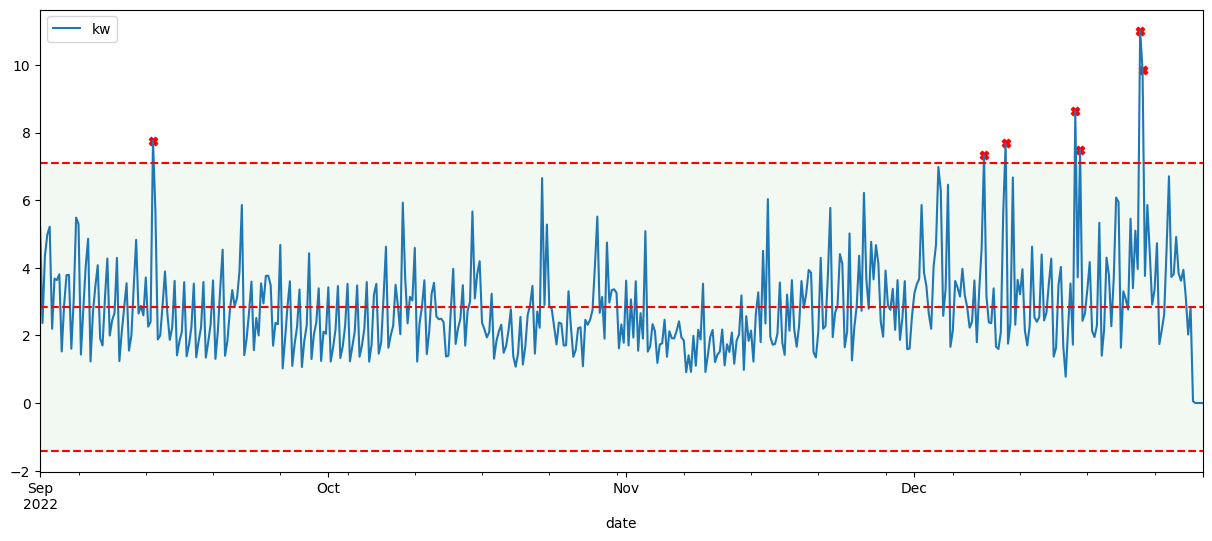

In [6]:
plot_outliers(df=df,
              potential_outliers=potential_outliers,
              h_lines_to_plot=[mean, mean - threshold*std_dev, mean + threshold*std_dev])

The method identified some peak values, possibly missing the last values which seem to indicate a major drop in the comsumption. Open the file and check it...

A more restrictive solution is to define smaller threshold value

mean: 2.848022680412371
std: 1.417667134716904

Potential outliers:
date
2022-09-12 18:00:00     7.756
2022-09-13 00:00:00     5.699
2022-09-22 00:00:00     5.857
2022-10-08 18:00:00     5.926
2022-10-23 06:00:00     6.652
2022-11-15 18:00:00     6.031
2022-11-22 06:00:00     5.770
2022-11-25 18:00:00     6.216
2022-12-01 18:00:00     5.856
2022-12-03 12:00:00     6.978
2022-12-03 18:00:00     6.279
2022-12-04 12:00:00     6.455
2022-12-08 06:00:00     7.331
2022-12-10 12:00:00     7.676
2022-12-11 06:00:00     6.670
2022-12-17 18:00:00     8.640
2022-12-18 06:00:00     7.490
2022-12-22 00:00:00     6.076
2022-12-22 06:00:00     5.940
2022-12-24 12:00:00    11.016
2022-12-24 18:00:00     9.846
2022-12-25 06:00:00     5.856
2022-12-27 12:00:00     6.706
2022-12-30 06:00:00     0.000
2022-12-30 12:00:00     0.000
2022-12-30 18:00:00     0.000
2022-12-31 00:00:00     0.000
Name: kw, dtype: float64


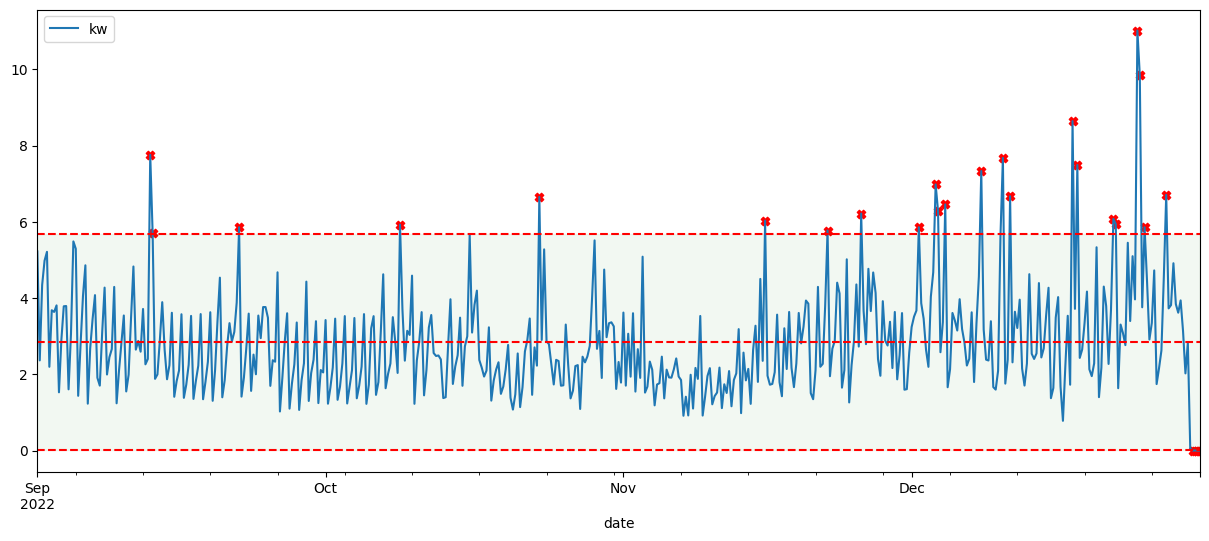

In [7]:
#define the threshold
threshold = 2

# call the z_score method
potential_outliers, mean, std_dev = z_score(df.kw, threshold)

print()
print("Potential outliers:")
print(potential_outliers)

# plot the results
plot_outliers(df=df,
              potential_outliers=potential_outliers,
                h_lines_to_plot=[mean, mean - threshold*std_dev, mean + threshold*std_dev])


The risk of diminishing the threshold is to increase the number of false positives, i.e., data points that are identified as outliers but are not. This is a trade-off that needs to be considered when choosing the threshold value for the Z-score method. In practice, the threshold value can be adjusted based on the specific characteristics of the data and the goals of the analysis.

A big number of false positives can be a problem, as maintenance teams, with time, may start to ignore the alerts, as they are not real. This can lead to a decrease in the effectiveness of the anomaly detection system and increase the risk of missing real anomalies.

### Grubbs' test

**Grubbs' test** identifies the most extreme data point in a univariate dataset. It calculates the G-statistic for each data point and compares it to the critical value of the G-statistic for a given significance level. If the G-statistic for a data point is greater than the critical value, the data point is considered an outlier.

This is a parametric test that assumes the data is normally distributed. The test compares the absolute difference between an observed data point and the sample mean to the standard deviation of the sample, and if this difference is found to be unusually large, the data point is considered an outlier.

Grubbs' test can be used to detect a single outlier in a dataset or multiple outliers. To perform the test, the following steps can be taken:

1. Determine the Grubbs' test **null hypothesis: _the dataset is normally distributed and contains no outliers_.**

2. Calculate the test statistic: The test statistic is the largest difference between a data point and the sample mean, divided by the sample standard deviation. This is represented by the formula:
$$G = \frac{\max(|X_i - \bar X|)}{\sigma}$$
where $X_i$ is the $i$-th data point, $\bar X$ is the sample mean, and $\sigma$ is the sample standard deviation.

3. Determine the critical value: The critical value is determined based on the significance level, degrees of freedom, and the number of data points in the dataset. The critical value is used to determine whether the test statistic is large enough to reject the null hypothesis, value determined by:
$$ G_{critical} = \frac{N-1}{\sqrt{N}} \sqrt{\frac{t^2_{\frac{\alpha}{2N}, N-2}}{N-2+t^2_{\frac{\alpha}{2N}, N-2}}}$$
with $t_{\alpha/(2N),N-2}$ denoting the critical value of the $t-$distribution with $N-2$ degrees of freedom and a significance level of $\alpha/(2N)$.

4. Compare the test statistic to the critical value: If the test statistic is greater than the critical value, then the null hypothesis is rejected, and the data point corresponding to the test statistic is considered an outlier. I.e., **if $G > G_{critical}$, then the data is not normally distributed or contains an outlier.**

Grubbs' test is widely used in many fields, including engineering, environmental science, and finance, where it can be used to detect anomalies in data such as pollutant concentrations, sensor readings, and financial returns.

In [8]:
import scipy.stats
import numpy as np

def grubbs_test(series, alpha):
    """
    x: vector of values
    alpha: "significance"
    """
    # calculate mean and standard deviation
    n = len(series)
    mean = np.mean(series)
    sts_dev = np.std(series)

    # calculate test statistic
    t_value = scipy.stats.t.ppf(1 - alpha / (2 * n), n - 2)

    # calculate critical value
    g_critical = (n - 1) * np.sqrt( np.square(t_value) / (n * (n - 2 + np.square(t_value))))
    print("Grubbs Critical Value:",g_critical)

    # find and return outliers
    return g_critical > abs(series - mean) / sts_dev, g_critical

In [9]:
test_results, g_critical = grubbs_test(df.kw.values, alpha=0.05)
potential_outliers = df[~test_results]

print('Potential outliers:')
print(potential_outliers)

Grubbs Critical Value: 3.855050051323008
Potential outliers:
                         kw
date                       
2022-12-17 18:00:00   8.640
2022-12-24 12:00:00  11.016
2022-12-24 18:00:00   9.846


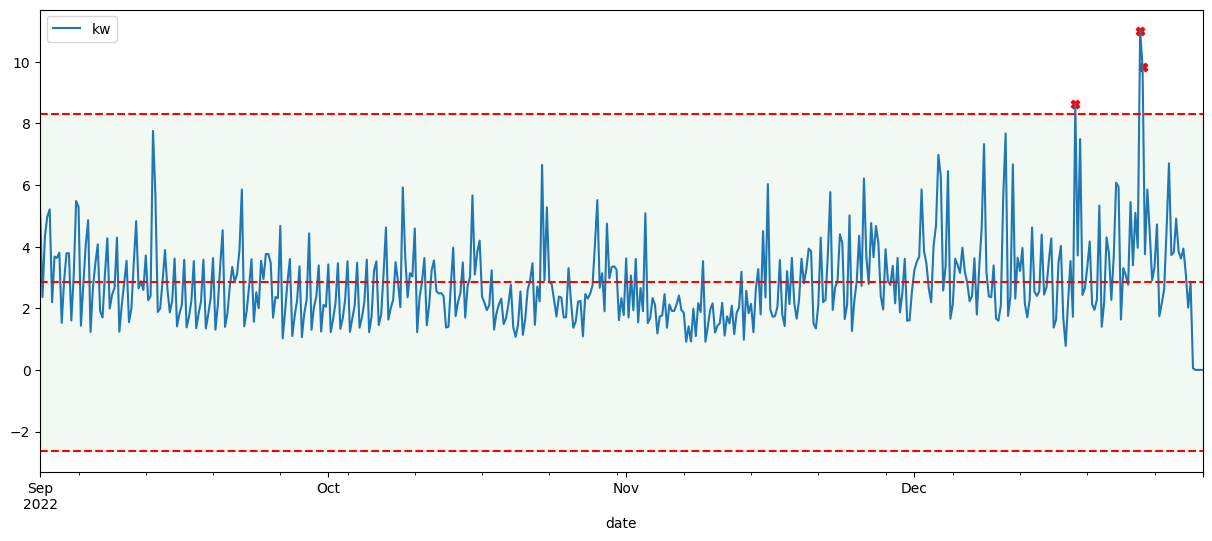

In [10]:
plot_outliers(df=df,
              potential_outliers=potential_outliers,
              h_lines_to_plot=[mean, mean - g_critical*std_dev, mean + g_critical*std_dev])

Different levels of significance can be used to determine the critical value. For example, a significance level of 0.05 is commonly used, which corresponds to a 95% confidence level. This means that if the test is performed multiple times, 95% of the time the test will correctly identify the outlier. However, this also means that 5% of the time the test will incorrectly identify a data point as an outlier, even though it is not.

### Modified Z-score method

The **modified Z-score** method is a variation of the Z-score method that is **more robust to outliers**. It uses the median absolute deviation (MAD) instead of the standard deviation to calculate the Z-score. Typically, data points with modified Z-scores greater than 3.5 or less than -3.5 are considered anomalies.

The median absolute deviation (MAD) is a measure of the variability of a univariate dataset. It is a robust alternative to the standard deviation that is less sensitive to outliers in the data. MAD is calculated as the median of the absolute deviations of the data points from their median.

The MAD of a dataset can be computed using the following formula:
$$MAD = median(|x_i - median(X)|)$$
where $x_i$ is the $i$-th observation in the dataset $X$ and $median(X)$ is the median of $X$.

Then the modified Z-score for each data point is calculated as:
$$M_i = 0.6745 \frac{x_i - median(X)}{MAD}$$
where 
- $M_i$ is the modified Z-score for the $i$-th data point, 
- $x_i$ is the $i$-th observation in the dataset $X$, 
- $median(X)$ is the median of $X$,  
- $MAD$ is the median absolute deviation of $X$, and
- the constant 0.6745 in the numerator is used to ensure that the modified Z-score behaves like a standard Z-score for large samples of normal data, where a score of approximately ±3.5 suggests an outlier.

In [11]:
from math import fabs

def modified_z_score(df, threshold=3):
    # calculate median absolute deviation
    median = df.kw.median()
    mad = (df.kw - median).apply(fabs).median()

    print(f'median: {median}')
    print(f'MAD: {mad}')

    # calculate modified Z-scores for each data point
    m_z_scores = 0.6745 * (df.kw - median) / mad

    # identify data points above threshold as potential outliers
    query = (m_z_scores < -threshold) | (m_z_scores > threshold)
    potential_outliers = df[query]

    return potential_outliers

In [12]:
threshold = 3.5
potential_outliers = modified_z_score(df, threshold)

print()
print("Potential outliers:")
potential_outliers

median: 2.499
MAD: 0.8270000000000002

Potential outliers:


,kw
date,
2022-09-12 18:00:00,7.756
2022-12-03 12:00:00,6.978
2022-12-08 06:00:00,7.331
2022-12-10 12:00:00,7.676
2022-12-17 18:00:00,8.640
2022-12-18 06:00:00,7.490
2022-12-24 12:00:00,11.016
2022-12-24 18:00:00,9.846


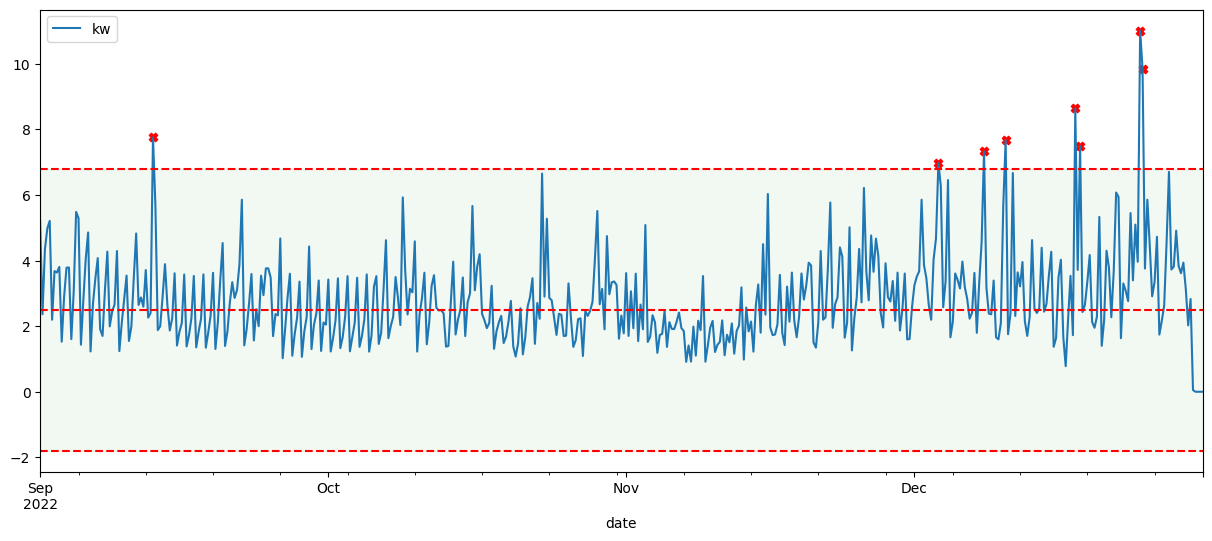

In [13]:
median = df.kw.median()
mad = (df.kw - median).apply(fabs).median()

plot_outliers(df=df,
              potential_outliers=potential_outliers,
              h_lines_to_plot=[median, median - threshold*mad/0.6745, median + threshold*mad/0.6745])

### Percentile method
The percentile method identifies data points that fall outside a certain percentile range. For example, data points that fall outside the 1st and 99th percentiles may be considered anomalies.


In [14]:
p01 = df.kw.quantile(0.01)
p99 = df.kw.quantile(0.99)
query = (df.kw < p01) | (df.kw > p99)

potential_outliers = df[query]

print()
print("Potential anomalies:")
potential_outliers


Potential anomalies:


,kw
date,
2022-09-12 18:00:00,7.756
2022-12-10 12:00:00,7.676
2022-12-17 18:00:00,8.640
2022-12-24 12:00:00,11.016
2022-12-24 18:00:00,9.846
2022-12-30 00:00:00,0.053
2022-12-30 06:00:00,0.000
2022-12-30 12:00:00,0.000
2022-12-30 18:00:00,0.000


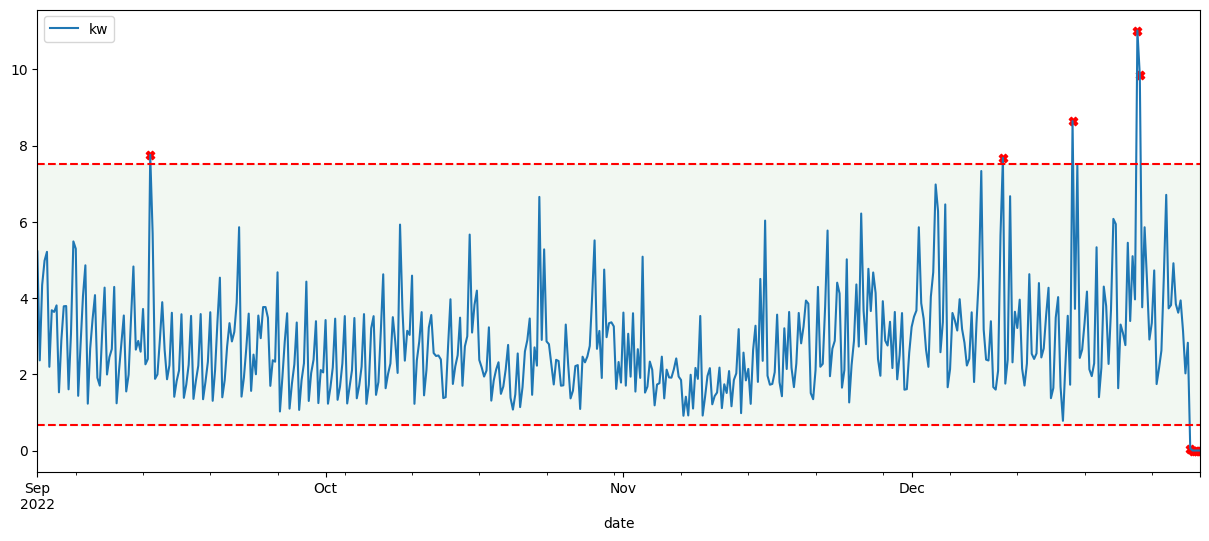

In [15]:
# plot it
plot_outliers(df=df,
              potential_outliers=potential_outliers,
              h_lines_to_plot=[p01, p99])

### Box plot method

The box plot method uses the interquartile range (IQR) to identify outliers. The box plot consists of a box and whiskers that represent the distribution of the data. The box represents the middle 50% of the data, with the bottom of the box indicating the 25th percentile and the top indicating the 75th percentile. The whiskers extend from the box to the minimum and maximum values, but they do not include any points that are identified as outliers. 

To identify outliers, the interquartile range (IQR) is used. The interquartile range (IQR) is the distance between the 25th (Q1) and 75th (Q3) percentiles of the data. You can compute the IQR by subtracting the 25th percentile from the 75th percentile, i.e.,

$$IQR = Q3 - Q1$$

Then to identify outliers using a box plot, you need to look for any points that fall outside the whiskers. The whiskers extend to 1.5 times the IQR below the 25th percentile and above the 75th percentile. Any point that falls outside the whiskers is considered an outlier.

It's important to note that not all data sets have outliers. If your data set has no outliers, then the whiskers on the box plot will extend to the minimum and maximum values of the data.

In [16]:
q1 = df.kw.quantile(.25)
q3 = df.kw.quantile(.75)

iqr = q3 - q1

print('q1 = ', q1)
print('q3 = ', q3)
print('iqr = ', iqr)

query = (df.kw < q1 - 1.5*iqr) | (df.kw > q3 + 1.5*iqr)
potential_outliers = df[query]

print()
print("Potential outliers:")
print(potential_outliers)

q1 =  1.852
q3 =  3.578
iqr =  1.7259999999999998

Potential outliers:
                         kw
date                       
2022-09-12 18:00:00   7.756
2022-10-23 06:00:00   6.652
2022-11-25 18:00:00   6.216
2022-12-03 12:00:00   6.978
2022-12-03 18:00:00   6.279
2022-12-04 12:00:00   6.455
2022-12-08 06:00:00   7.331
2022-12-10 12:00:00   7.676
2022-12-11 06:00:00   6.670
2022-12-17 18:00:00   8.640
2022-12-18 06:00:00   7.490
2022-12-24 12:00:00  11.016
2022-12-24 18:00:00   9.846
2022-12-27 12:00:00   6.706


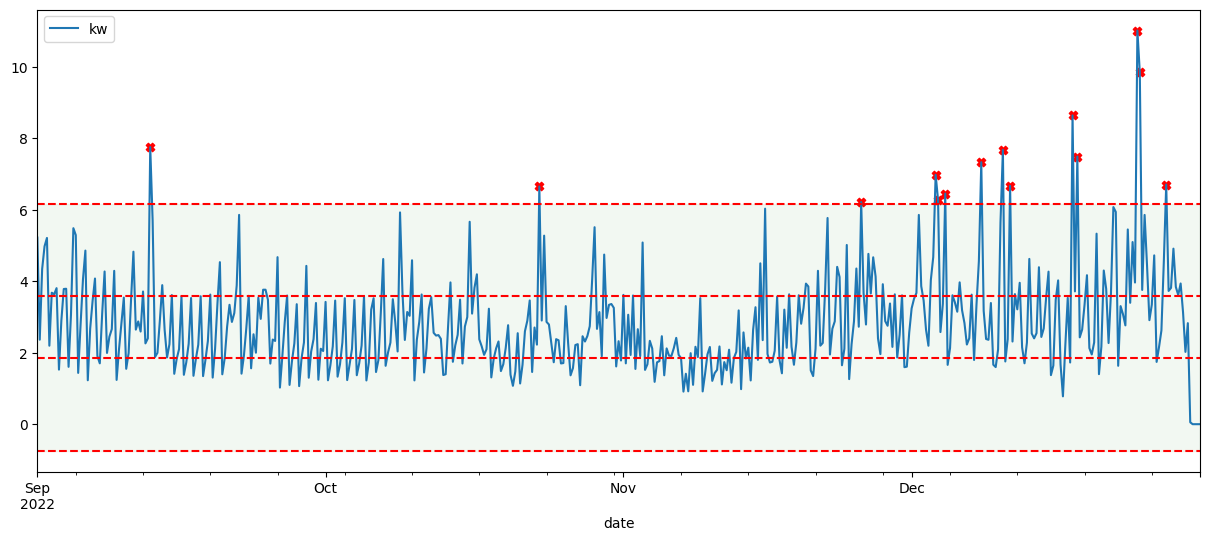

In [17]:
plot_outliers(df=df,
              potential_outliers=potential_outliers,
              h_lines_to_plot=[q1, q3, q1 - 1.5*iqr, q3 + 1.5*iqr])

Ploting in parallel with the boxplot and timeseries plot

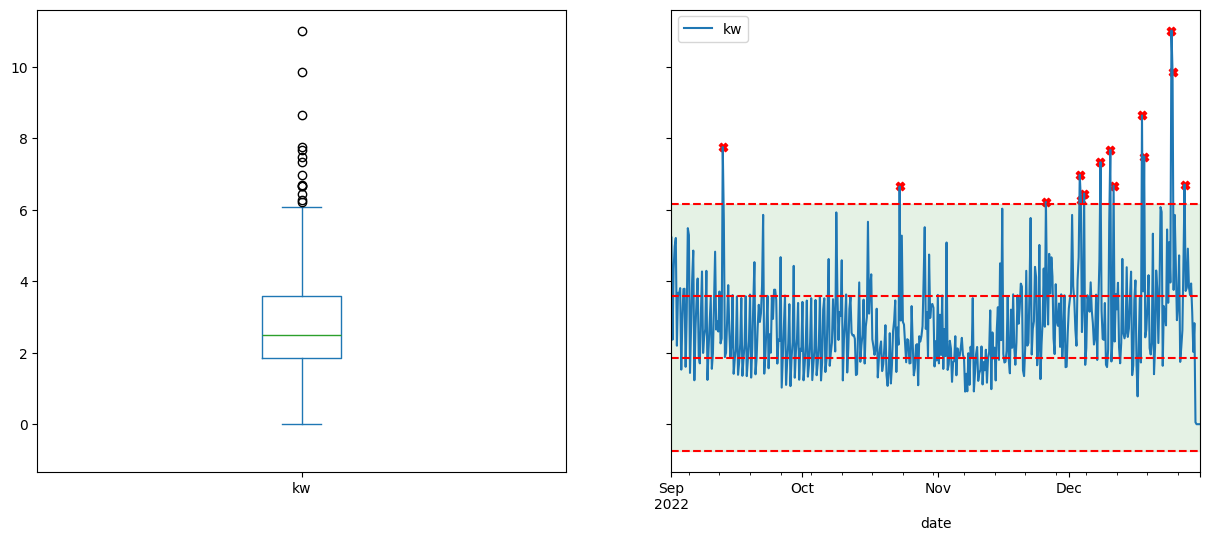

In [18]:
fig, ax = plt.subplots(1, 2, sharey=True)

# plot the boxplot
df.kw.plot(kind='box', ax=ax[0])

# timeseries plot
df.plot(figsize=(15, 6), ax=ax[1])
ax[1].scatter(x=potential_outliers.index.values, y=potential_outliers.kw.values, marker='X', c='r')

# plot horizontal lines 
for y in [q1, q3, q1 - 1.5*iqr, q3 + 1.5*iqr]:
    ax[1].axhline(y, color = 'r', linestyle = '--')

ax[1].fill_between(x=df.index.values,
                   y1=q1 - 1.5*iqr,
                   y2=q3 + 1.5*iqr,
                   alpha=0.1, color="g")

### Moving average method 


The moving average method is a commonly used technique to identify anomalies or outliers in a time series dataset. Here's how to use the moving average method to compute anomalies:

- **Step 1: Choose a window size**
The first step is to choose a window size, which is the number of data points to include in each moving average calculation. The window size should be large enough to smooth out any noise in the data but small enough to capture any sudden changes in the data.

- **Step 2: Calculate the moving average**
Next, calculate the moving average for each window. To do this, take the average of the data points within the window. 

- **Step 3: Calculate the deviation from the moving average**
Calculate the deviation from the moving average for each data point. To do this, subtract the moving average for the window from the value of the data point. The result is the deviation from the moving average.

- **Step 4: Identify anomalies**
Anomalies are data points that deviate significantly from the moving average. One common method for identifying anomalies is to use the standard deviation of the deviations as a threshold. For example, if a data point deviates from the moving average by more than three times the standard deviation of the deviations, it can be considered an anomaly.

- **Step 5: Visualize the results**
Finally, it's important to visualize the results of the moving average method to identify any anomalies in the dataset.

In [19]:
# define the windows size
window_size = 12

# make of the copy of the data
df_mam = df.copy()

# Calculate the moving average
df_mam['moving_average'] = df_mam.kw.rolling(window_size, min_periods=1).mean()

# Calculate the deviation from the moving average
df_mam['deviation'] = df_mam.kw - df_mam.moving_average

# Calculate the standard deviation of the deviations
std_dev = df_mam.deviation.std()

# Identify anomalies
threshold = 3
query = (df_mam.deviation < -threshold*std_dev) | (df_mam.deviation > threshold*std_dev)
potential_anomalies = df_mam.kw[query]

print("Potential anomalies:")
print(potential_anomalies)

Potential anomalies:
date
2022-09-12 18:00:00     7.756
2022-10-23 06:00:00     6.652
2022-12-08 06:00:00     7.331
2022-12-10 12:00:00     7.676
2022-12-17 18:00:00     8.640
2022-12-18 06:00:00     7.490
2022-12-24 12:00:00    11.016
2022-12-24 18:00:00     9.846
Name: kw, dtype: float64


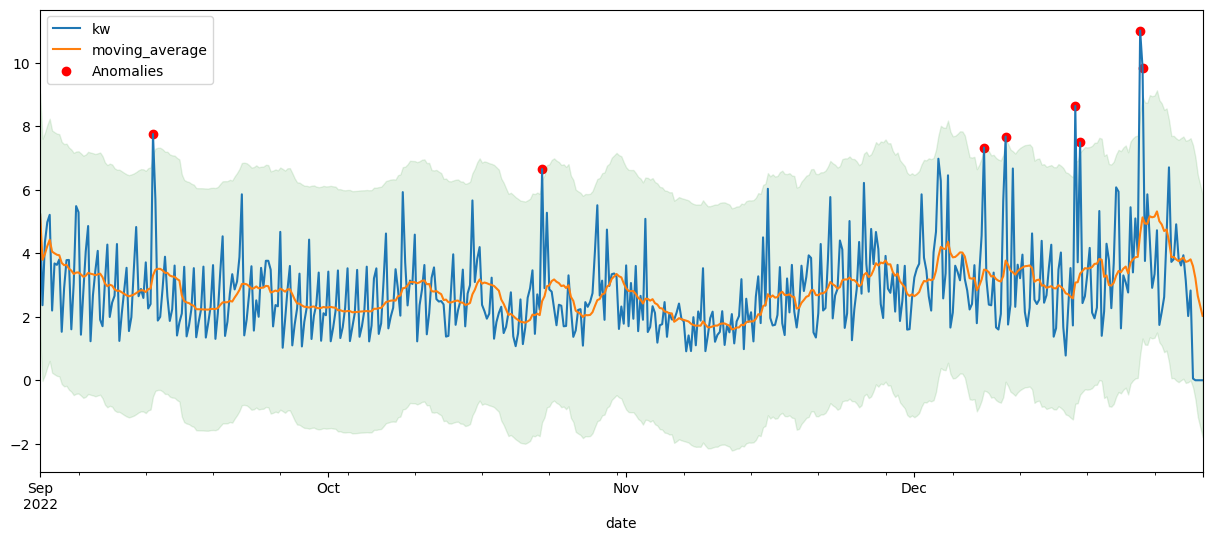

In [20]:
# Visualize the results
ax=df_mam[['kw', 'moving_average']].plot(figsize=(15, 6))

# plot the tolerance bandhe 
ax.scatter(x=potential_anomalies.index.values, y=potential_anomalies.values, color='red', label='Anomalies')
ax.fill_between(x=df_mam.index.values,
                y1=(df_mam.moving_average.values-threshold*std_dev),
                y2=(df_mam.moving_average.values+threshold*std_dev),
                alpha=0.1, color="g")
plt.legend()

### Exponential smoothing method

Exponential smoothing is a time series analysis method that can be used for outlier detection. Exponential smoothing is a weighted average method that gives more weight to recent observations and less weight to older observations. This method is particularly useful for detecting outliers that occur in a time series dataset with a seasonal or trend component.

Here's how to use exponential smoothing for outlier detection:

- **Step 1: Choose a smoothing factor**
The first step is to choose a smoothing factor ($\alpha$) between 0 and 1. _**A smaller value of $\alpha$ gives more weight to older observations, while a larger value of $\alpha$ gives more weight to recent observations**_.

- **Step 2: Calculate the smoothed values**
Next, calculate the smoothed values for each data point using exponential smoothing. The smoothed value at time $t$ is given by:
$$ \left\{\begin{array}{l} s_0 = y_0 \\ s_t = \alpha  y_t + (1 - \alpha) s_{t-1}  \end{array}\right.$$ where $y_t$ is the observed value at time $t$, and $s_{t-1}$ is the smoothed value at the previous time step.

- **Step 3: Calculate the deviation**
Calculate the deviation between the observed value and the smoothed value for each data point. The deviation is given by:
$$\delta_t = y_t - s_t$$

- **Step 4: Calculate the deviation standard deviation**
Calculate the standard deviation of the deviations. This can be used to determine a threshold for identifying outliers.

- **Step 5: Identify outliers**
Anomalies are data points that deviate significantly from the smoothed values. One common method for identifying outliers is to use a threshold of 3 times the standard deviation of the deviations. For example, if a data point deviates from the smoothed value by more than three times the standard deviation of the deviations, it can be considered an outlier.

- **Step 6: Visualize the results**
Finally, it's important to visualize the results of the exponential smoothing method to identify any outliers in the dataset. Plot the original data and the smoothed values on a graph and mark any data points that are identified as outliers.


In [21]:
def exponential_smoothing_anomaly_detector(df, alpha=0.5, threshold=3):
    # make of the copy of the data as the function will modify it
    df_es = df.copy()

    # step 2 - calculate the smoothed values
    df_es['s'] = df_es.kw
    for t_minus_1, t in zip(df_es.index[:-1], df_es.index[1:]):
        df_es.loc[t, 's'] = alpha * df_es.loc[t, 'kw'] + (1-alpha)*df_es.loc[t_minus_1, 's']

    # step 3 - calculate the deviation
    df_es['deviation'] = df_es.kw - df_es.s

    # step 4 - calculate the standard deviation of the deviations
    std_dev = df_es.deviation.std()

    # Identify anomalies - those points whose absolute deviation exceeds threshold x standard deviations
    query = (df_es.deviation < -threshold*std_dev) | (df_es.deviation > threshold*std_dev)
    potential_outliers = df_es.kw[query]

    print()
    print("Potential anomalies:")
    print(potential_outliers)
    return potential_outliers, df_es, std_dev

In [22]:
# define the smoothing factor and threshold
alpha = 0.5
threshold = 2

# run exponential smoothing and identify potential outliers
potential_outliers, df_es, std_dev = exponential_smoothing_anomaly_detector(df, alpha=alpha, threshold=threshold)


Potential anomalies:
date
2022-09-05 06:00:00     1.435
2022-09-06 06:00:00     1.229
2022-09-12 18:00:00     7.756
2022-09-13 06:00:00     1.880
2022-09-22 06:00:00     1.414
2022-10-08 18:00:00     5.926
2022-10-16 00:00:00     5.664
2022-10-23 06:00:00     6.652
2022-11-03 00:00:00     5.084
2022-11-15 18:00:00     6.031
2022-11-25 18:00:00     6.216
2022-12-03 12:00:00     6.978
2022-12-04 00:00:00     2.578
2022-12-04 18:00:00     1.660
2022-12-08 06:00:00     7.331
2022-12-10 06:00:00     5.650
2022-12-10 12:00:00     7.676
2022-12-10 18:00:00     1.755
2022-12-11 06:00:00     6.670
2022-12-17 18:00:00     8.640
2022-12-18 06:00:00     7.490
2022-12-18 12:00:00     2.430
2022-12-20 06:00:00     5.331
2022-12-22 12:00:00     1.634
2022-12-24 12:00:00    11.016
2022-12-25 00:00:00     3.757
2022-12-27 12:00:00     6.706
Name: kw, dtype: float64


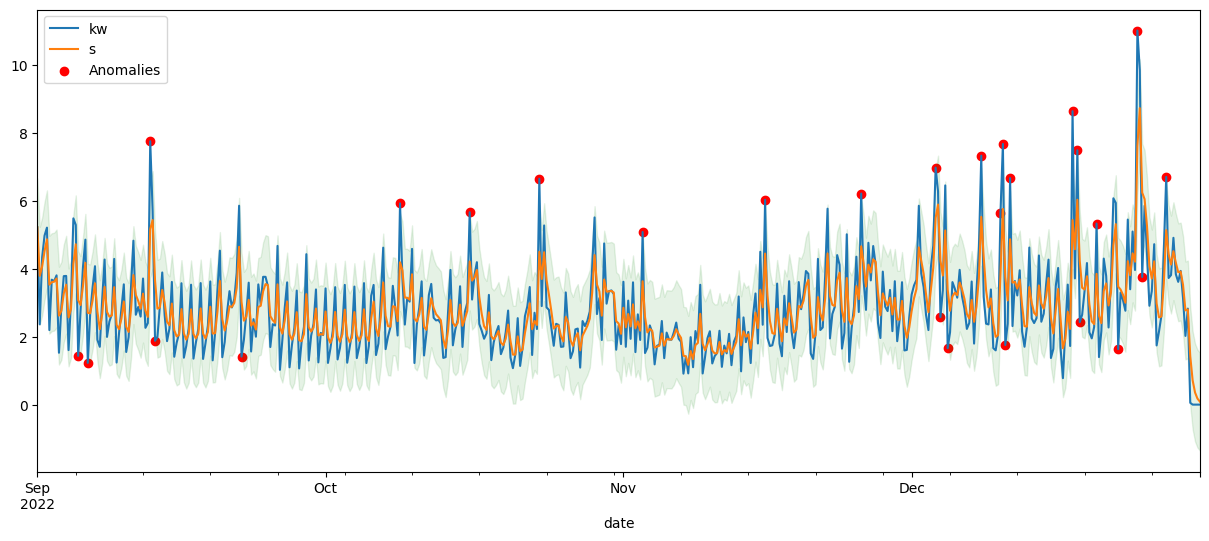

In [23]:
# Visualize the results
df_es.kw.plot(figsize=(15, 6))
df_es.s.plot()

# plot the tolerance bandhe 
plt.scatter(x=potential_outliers.index.values, y=potential_outliers.values, color='red', label='Anomalies')

# plot the tolerance band
plt.fill_between(x=df_es.index.values,
                 y1=(df_es.s.values-threshold*std_dev),
                 y2=(df_es.s.values+threshold*std_dev),
                 alpha=0.1, color="g")
plt.legend()
plt.show()

## Machine learning methods

As mentioned, many applications require the ability to determine whether a new observation should be treated as a novel observation or as an inlier that belongs to the same distribution as current data. This skill is frequently applied to sanitize actual data sets. There are two key differences that must be made: 

- **Identification of outliers: outliers are defined as observations that deviate significantly from the norm in the training data**. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.

- **Novelty detection: The training data is not polluted by outliers and we are interested in recognizing whether a new observation is an outlier**. An outlier is sometimes referred to as a novelty in this context.

Outlier detection and novelty detection are both used for anomaly detection, where one is interested in detecting abnormal or unusual observations. Outlier detection is then also known as **unsupervised anomaly detection** and novelty detection as **semi-supervised anomaly detection**. In the context of outlier detection, the outliers/anomalies cannot form a dense cluster as available estimators assume that the outliers/anomalies are located in low density regions. On the contrary, in the context of novelty detection, novelties/anomalies can form a dense cluster as long as they are in a low density region of the training data, considered as normal in this context.

### Types of data available

Anomaly detection in time series data can be performed using supervised, semi-supervised, unsupervised or active semi-supervised techniques, depending on the availability and nature of labeled data.

- __Supervised anomaly detection__: In supervised anomaly detection, the model is trained on labeled data, which means the data is already classified as normal or anomalous. The model learns to classify new data points based on this labeled data. This approach requires a significant amount of labeled data, which may not always be available in the case of anomaly detection in time series.

- __Semi-supervised anomaly detection__: In semi-supervised anomaly detection, some of the data points are labeled as normal or anomalous, while others are unlabeled. The model is trained on this partially labeled data and learns to classify the unlabeled data points as normal or anomalous based on the patterns it has learned from the labeled data. This approach can be useful when there is a limited amount of labeled data available. For some authors, also refer to semi-supervised anomaly detection when data used to do the training is considered as not containing anomalous points.

- __Unsupervised anomaly detection__: In unsupervised anomaly detection, the model is trained on unlabeled data only and learns to identify anomalies based on the patterns it observes in the data. This approach does not require labeled data, which can be advantageous in cases where labeling the data is difficult or expensive.

- __Active semi-supervised anomaly detection__: Active semi-supervised anomaly detection is a technique where the algorithm actively selects the most informative samples to be labeled by an expert. The algorithm iteratively selects samples that are uncertain or likely to be anomalies and requests the expert to label them. The labeled samples are then incorporated into the model, and the process is repeated until the model's performance reaches a desired level or no more informative samples can be found. This approach can be useful when the labeling process is expensive or time-consuming and labeling all samples in a dataset is not feasible. It can also be useful when the anomaly detection task is highly dependent on domain expertise, and the algorithm can leverage the knowledge of an expert to improve its performance.

### Methods
There are several machine learning techniques that can be used for outlier detection on time series data. Some commonly used ones are:

- **One-Class SVM (Support Vector Machine)**: This is a popular method for detecting outliers in time series data. One-Class SVM builds a model of the normal behavior of the time series and then identifies any data points that fall outside of this normal range as outliers.

- **Isolation Forest**: This is a tree-based algorithm that works by randomly selecting features and splitting data points based on those features until each data point is isolated in its own tree. Data points that require fewer splits to isolate are considered to be outliers.

- **Autoencoder**: Autoencoders are a type of neural network that can be used for unsupervised anomaly detection. The network is trained on the normal behavior of the time series data and then any data points that are significantly different from the normal behavior are identified as outliers.

- **LSTM (Long Short-Term Memory)**: LSTM is a type of recurrent neural network that is well-suited for time series data. It can be used to detect anomalies by learning the normal patterns of the time series data and then identifying any data points that deviate significantly from those patterns.

- Etc.

These methods have the advantage of being able to **learn complex patterns in the time series data** and can be effective at detecting anomalies that are not easily identified using traditional statistical methods.  This is **particularly useful when the data is high-dimensional or has a large number of features** that are difficult to analyze using traditional statistical techniques.


The choice of which technique to use will depend on the specific characteristics of your time series data and the goals of your analysis. Next we will some examples of the first three.



#### One-Class SVM

One-Class SVM (Support Vector Machine) is a type of SVM that is used for anomaly detection, which is a machine learning technique to identify unusual patterns or data points in a given dataset.

Unlike traditional SVMs, One-Class SVM does not require a set of labeled data points for training. Instead, it uses a single class of data points to model the normal behavior of the dataset and then identifies the outliers or anomalies that deviate from this normal behavior.

One-Class SVM works by constructing a hyperplane that separates the normal data points from the outliers. The hyperplane is positioned in such a way that it maximizes the margin between the hyperplane and the normal data points, while still capturing as many normal data points as possible. The outliers are then identified as the data points that fall outside the hyperplane.

Let us see an example of how to use the One-Class SVM (Support Vector Machine) implementation available at the Scikit Learn package

In [24]:
import numpy as np
from sklearn.svm import OneClassSVM

# load data and resample it to hourly consumption
df_hourly = pd.read_csv('./data/house_consumption_TS/house_consumption.csv', parse_dates=['date'])\
    .set_index('date')\
    .resample('h')\
    .mean()\
    .fillna(0)

# select the data for the months of September to December 2022
mask = (df_hourly.index >= '2022-09-01') & (df_hourly.index <= '2022-12-31')
df_hourly = df_hourly[mask]


# build a dataframe with the consumption and associated hour of the day - adding features helps the method to identify anomalies, e.g., a anomalous consumption at a certain time
data = pd.DataFrame()
data.index = df_hourly.index
data['kw'] = df_hourly.kw
data['h'] = df_hourly.index.hour

# other possible features could be the week day, month, etc
# data['wd'] = df_hourly.index.weekday
# data['month'] = df_hourly.index.month

data.head()

,kw,h
date,,
2022-09-01 00:00:00,0.527,0
2022-09-01 01:00:00,0.672,1
2022-09-01 02:00:00,0.875,2
2022-09-01 03:00:00,1.253,3
2022-09-01 04:00:00,0.944,4


To prepare the data for the One-Class SVM model, we can create a sliding window of size 24 (hours). This "captures" the behaviour of the consumption at a certain moment. The window size is a hyperparameter that can be tuned to improve the performance of the model.

In [25]:
# Prepare the data by creating a sliding window of size 24 (hours).
# This "captures" the behaviour of the consumption at a certain moment
window_size = 24

# create a sliding window of size 24 (hours)
X = np.array([data[i:i+window_size] for i in range(len(data)-window_size+1)])
print('Shape of the data after creating the sliding window:', X.shape)

# flatten the data
X = np.reshape(X, (X.shape[0], -1))
print('Shape of the data after flattening:', X.shape)

# convert to a dataframe
X = pd.DataFrame(X)

# to use the index of the first reading as reference
X.index = data.index[:-(window_size-1)]
# to use the index of the last reading as reference
#X.index = data.index[window_size-1:]

X.head()

Shape of the data after creating the sliding window: (2882, 24, 2)
Shape of the data after flattening: (2882, 48)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
date,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00,0.527,0.0,0.672,1.0,0.875,2.0,1.253,3.0,0.944,4.0,...,0.982,19.0,0.764,20.0,0.911,21.0,0.643,22.0,0.564,23.0
2022-09-01 01:00:00,0.672,1.0,0.875,2.0,1.253,3.0,0.944,4.0,0.951,5.0,...,0.764,20.0,0.911,21.0,0.643,22.0,0.564,23.0,0.384,0.0
2022-09-01 02:00:00,0.875,2.0,1.253,3.0,0.944,4.0,0.951,5.0,0.252,6.0,...,0.911,21.0,0.643,22.0,0.564,23.0,0.384,0.0,0.349,1.0
2022-09-01 03:00:00,1.253,3.0,0.944,4.0,0.951,5.0,0.252,6.0,0.326,7.0,...,0.643,22.0,0.564,23.0,0.384,0.0,0.349,1.0,0.996,2.0
2022-09-01 04:00:00,0.944,4.0,0.951,5.0,0.252,6.0,0.326,7.0,0.240,8.0,...,0.564,23.0,0.384,0.0,0.349,1.0,0.996,2.0,1.025,3.0


In [26]:
# Train the One-Class SVM model
clf = OneClassSVM(nu=0.01,
                  kernel="rbf",
                  gamma=0.1)
clf.fit(X)

# Signed distance is positive for an inlier and negative for an outlier.
scores = clf.decision_function(X)

# Set the threshold to the 2-th percentile
threshold = np.percentile(scores, 5)

# find the samples outside the threshold
query = scores < threshold
potential_outliers = X[query]

potential_outliers.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
date,,,,,,,,,,,,,,,,,,,,,
2022-09-11 21:00:00,0.449,21.0,0.285,22.0,0.217,23.0,0.183,0.0,0.212,1.0,...,0.217,16.0,0.219,17.0,1.782,18.0,1.465,19.0,1.791,20.0
2022-09-12 00:00:00,0.183,0.0,0.212,1.0,0.534,2.0,0.904,3.0,0.934,4.0,...,1.465,19.0,1.791,20.0,1.123,21.0,0.737,22.0,0.858,23.0
2022-09-12 02:00:00,0.534,2.0,0.904,3.0,0.934,4.0,0.946,5.0,0.219,6.0,...,1.123,21.0,0.737,22.0,0.858,23.0,0.830,0.0,0.757,1.0
2022-09-12 15:00:00,0.178,15.0,0.217,16.0,0.219,17.0,1.782,18.0,1.465,19.0,...,0.227,10.0,0.181,11.0,0.189,12.0,0.856,13.0,0.295,14.0
2022-09-22 02:00:00,1.200,2.0,1.524,3.0,1.472,4.0,0.939,5.0,0.206,6.0,...,0.328,21.0,0.357,22.0,0.208,23.0,0.201,0.0,0.188,1.0


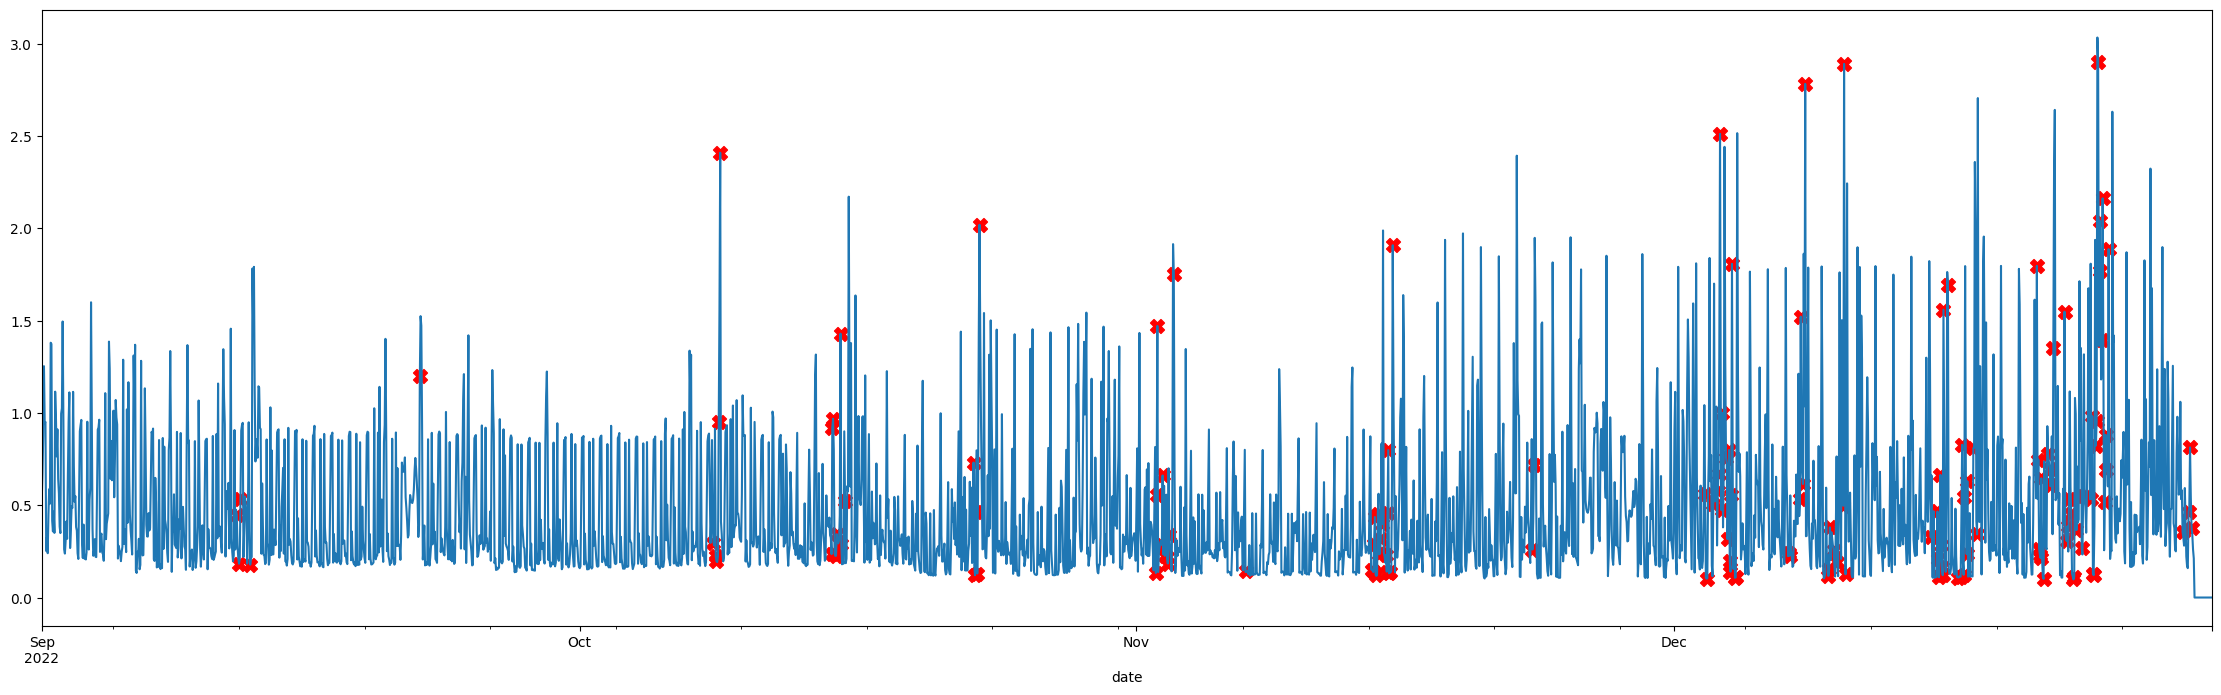

In [27]:
# Visualize the results
ax = data.kw.plot(figsize=(28,8))
ax.scatter(x=potential_outliers.index.values, y=data.kw[potential_outliers.index], marker='X', c='r', s=100)

One of the main problems with the **explainability** of the One-Class SVM is that it is a **black box** model, which means that it is difficult to understand how the model arrived at its predictions. This lack of transparency can make it challenging to interpret the results and understand the underlying reasoning behind them.

One of the reasons for this lack of transparency is that the One-Class SVM is a non-parametric model, which means that it does not have a fixed number of parameters that can be easily interpreted. Instead, the model is trained to optimize a complex objective function, which makes it difficult to understand how the model works internally.

Another reason for the lack of interpretability is that the One-Class SVM uses a kernel function to map the input data to a higher-dimensional space, where it can be more easily separated by a hyperplane. The choice of kernel function can have a significant impact on the performance of the model, but it can be difficult to understand how the kernel function affects the model's behavior.

To address these challenges, researchers are exploring different methods for improving the explainability of the One-Class SVM, such as using interpretable kernel functions or post-hoc explanations that provide insights into the model's decision-making process. However, achieving high levels of interpretability while maintaining the accuracy and effectiveness of the One-Class SVM remains an ongoing research challenge.


#### Isolation Forest

Isolation Forest is a machine learning algorithm used for anomaly detection, which is a technique to identify unusual patterns or data points in a given dataset. It works by constructing a tree structure where each split is made by randomly selecting a feature and a value within the range of the feature, which isolates the observations by creating partitions or sub-trees.

The basic idea behind Isolation Forest is that **anomalies are more likely to be isolated or separated from the rest of the data points in a few number of splits**, as opposed to normal data points which are more likely to be grouped together. Thus, the algorithm isolates anomalies faster and with fewer splits, compared to normal data points.

In the isolation process, the algorithm randomly selects a feature and a value, and creates a partition that isolates some of the data points. It repeats this process recursively until all data points are isolated, or until it reaches a predefined number of splits. The depth of each tree is limited, so as to avoid overfitting to the training data.

After constructing the trees, the algorithm calculates the anomaly score for each data point based on the average path length it takes to reach that point in all trees. Anomalies are identified as the data points with the highest scores. The formula for the anomaly score is given by:
$$s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$
where:
- $s$ is the anomaly score
- $x$ is the data point
- $n$ is the number of splits
- $E(h(x))$ is the expected value of the anomaly score
- $c(n)$ is the number of splits

Isolation Forest has several advantages over other anomaly detection methods, such as the **ability to handle high-dimensional datasets and large datasets, and the ability to detect anomalies in a short amount of time. However, it may not perform we**ll in detecting anomalies that are highly correlated with the normal data, and may require careful tuning of its hyperparameters to achieve good results.

![./images/IF_anomalous_point.png](./images/IF_anomalous_point.png)

##### Example 1

Let us see an example of how to use the Isolation Forest implementation available at the Scikit Learn package

In [28]:
data.head()

,kw,h
date,,
2022-09-01 00:00:00,0.527,0
2022-09-01 01:00:00,0.672,1
2022-09-01 02:00:00,0.875,2
2022-09-01 03:00:00,1.253,3
2022-09-01 04:00:00,0.944,4


In [29]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=50, # fit 50 trees
                      contamination=0.01) # move this value to be more/less strict

predictions = clf.fit_predict(data)

potencial_outliers = data[predictions == -1]
potencial_outliers

,kw,h
date,,
2022-09-12 18:00:00,1.782,18
2022-09-12 20:00:00,1.791,20
2022-10-08 20:00:00,2.409,20
2022-10-16 00:00:00,2.171,0
2022-11-03 02:00:00,1.914,2
2022-11-14 19:00:00,1.988,19
2022-11-15 22:00:00,1.638,22
2022-11-15 23:00:00,1.375,23
2022-11-22 06:00:00,2.393,6


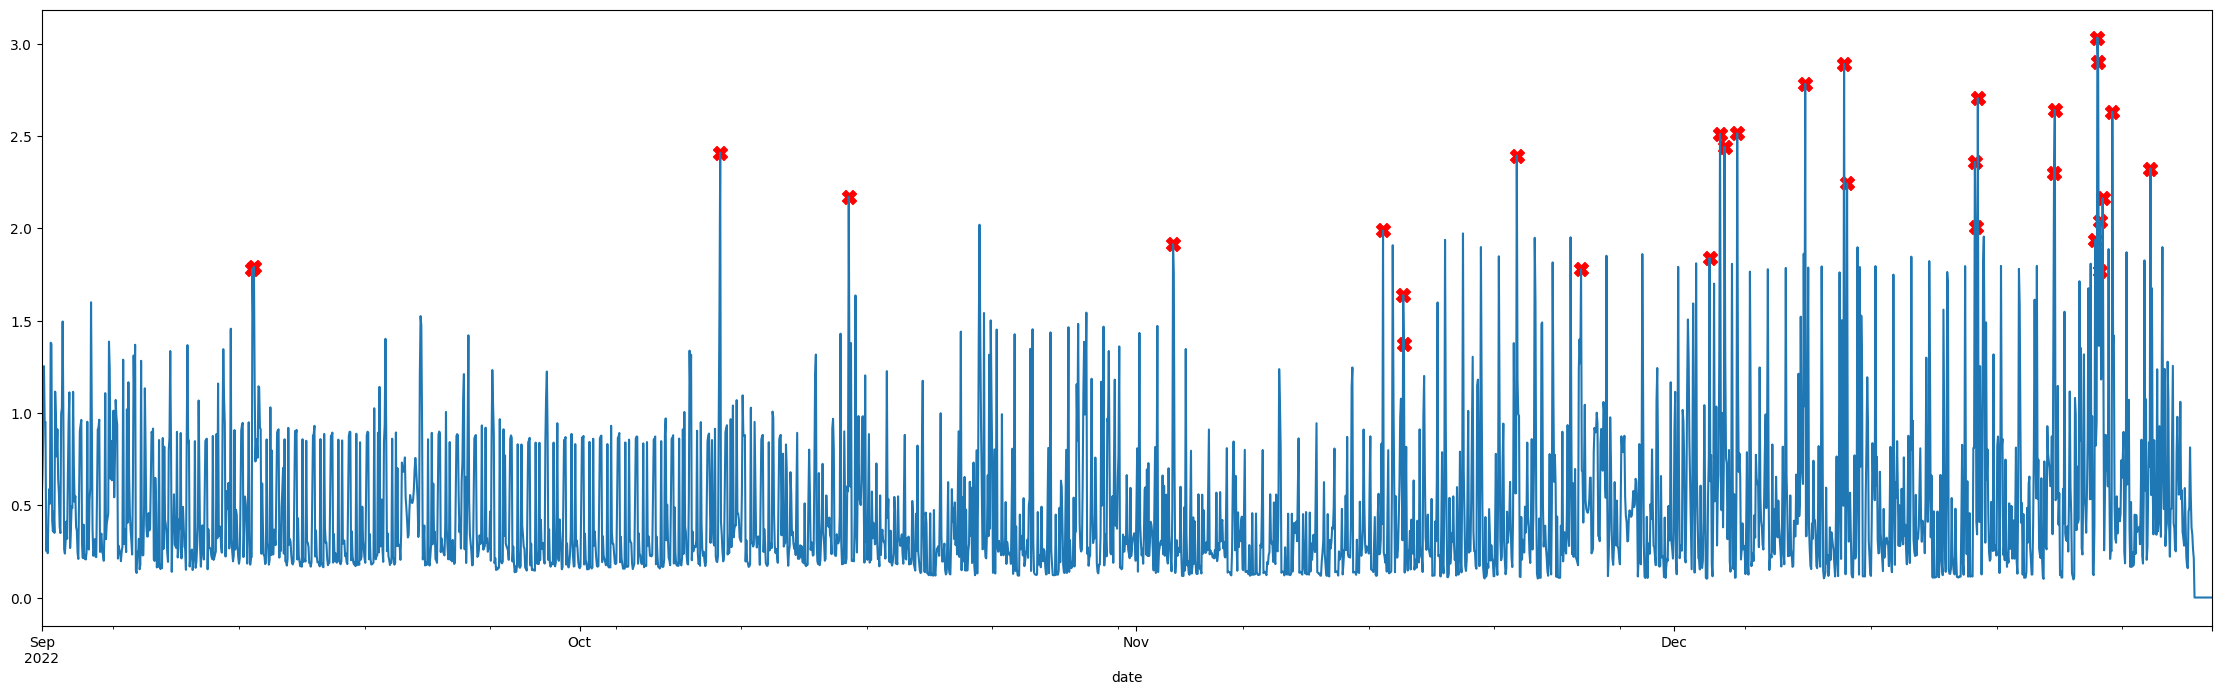

In [30]:
# Visualize the results
ax = data.kw.plot(figsize=(28,8))
ax.scatter(x=potencial_outliers.index.values, y=potencial_outliers.kw, marker='X', c='r', s=100)

##### Example 2
Let us see another example, now with a similar strategy as for the one class SVM, that is, the building of a window of data which is fed to the isolation forest algoritm

In [31]:
window_size = 24

X = np.array([data[i:i+window_size] for i in range(len(data)-window_size+1)])
X = np.reshape(X, (X.shape[0], -1))
X = pd.DataFrame(X)

# use the index of the first reading as reference 
X.index = data.index[window_size-1:] 
X.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
date,,,,,,,,,,,,,,,,,,,,,
2022-09-01 23:00:00,0.527,0.0,0.672,1.0,0.875,2.0,1.253,3.0,0.944,4.0,...,0.982,19.0,0.764,20.0,0.911,21.0,0.643,22.0,0.564,23.0
2022-09-02 00:00:00,0.672,1.0,0.875,2.0,1.253,3.0,0.944,4.0,0.951,5.0,...,0.764,20.0,0.911,21.0,0.643,22.0,0.564,23.0,0.384,0.0
2022-09-02 01:00:00,0.875,2.0,1.253,3.0,0.944,4.0,0.951,5.0,0.252,6.0,...,0.911,21.0,0.643,22.0,0.564,23.0,0.384,0.0,0.349,1.0
2022-09-02 02:00:00,1.253,3.0,0.944,4.0,0.951,5.0,0.252,6.0,0.326,7.0,...,0.643,22.0,0.564,23.0,0.384,0.0,0.349,1.0,0.996,2.0
2022-09-02 03:00:00,0.944,4.0,0.951,5.0,0.252,6.0,0.326,7.0,0.240,8.0,...,0.564,23.0,0.384,0.0,0.349,1.0,0.996,2.0,1.025,3.0


In [32]:
clf = IsolationForest(n_estimators=50,
                      contamination=0.01)
predictions = clf.fit_predict(X)  # fit 10 trees  

potencial_outliers = X[predictions == -1]
potencial_outliers

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
date,,,,,,,,,,,,,,,,,,,,,
2022-12-04 10:00:00,0.578,11.0,0.668,12.0,1.302,13.0,2.511,14.0,1.024,15.0,...,1.807,6.0,0.631,7.0,0.155,8.0,0.560,9.0,0.107,10.0
2022-12-11 07:00:00,0.209,8.0,1.502,9.0,1.030,10.0,0.497,11.0,2.890,12.0,...,0.211,3.0,0.236,4.0,0.679,5.0,1.897,6.0,0.623,7.0
2022-12-11 11:00:00,2.890,12.0,1.077,13.0,0.126,14.0,0.744,15.0,2.243,16.0,...,0.623,7.0,0.124,8.0,1.790,9.0,0.709,10.0,1.527,11.0
2022-12-18 10:00:00,0.117,11.0,0.457,12.0,0.113,13.0,0.117,14.0,0.115,15.0,...,1.809,6.0,1.955,7.0,1.299,8.0,0.297,9.0,1.490,10.0
2022-12-18 11:00:00,0.457,12.0,0.113,13.0,0.117,14.0,0.115,15.0,0.114,16.0,...,1.955,7.0,1.299,8.0,0.297,9.0,1.490,10.0,0.640,11.0
2022-12-18 12:00:00,0.113,13.0,0.117,14.0,0.115,15.0,0.114,16.0,0.810,17.0,...,1.299,8.0,0.297,9.0,1.490,10.0,0.640,11.0,0.802,12.0
2022-12-18 14:00:00,0.115,15.0,0.114,16.0,0.810,17.0,0.811,18.0,2.359,19.0,...,1.490,10.0,0.640,11.0,0.802,12.0,0.456,13.0,0.247,14.0
2022-12-18 18:00:00,2.359,19.0,2.009,20.0,0.414,21.0,0.342,22.0,2.705,23.0,...,0.247,14.0,0.199,15.0,0.208,16.0,0.518,17.0,0.281,18.0
2022-12-24 18:00:00,0.233,19.0,0.550,20.0,1.317,21.0,0.536,22.0,0.493,23.0,...,0.957,14.0,3.033,15.0,2.903,16.0,1.363,17.0,2.041,18.0


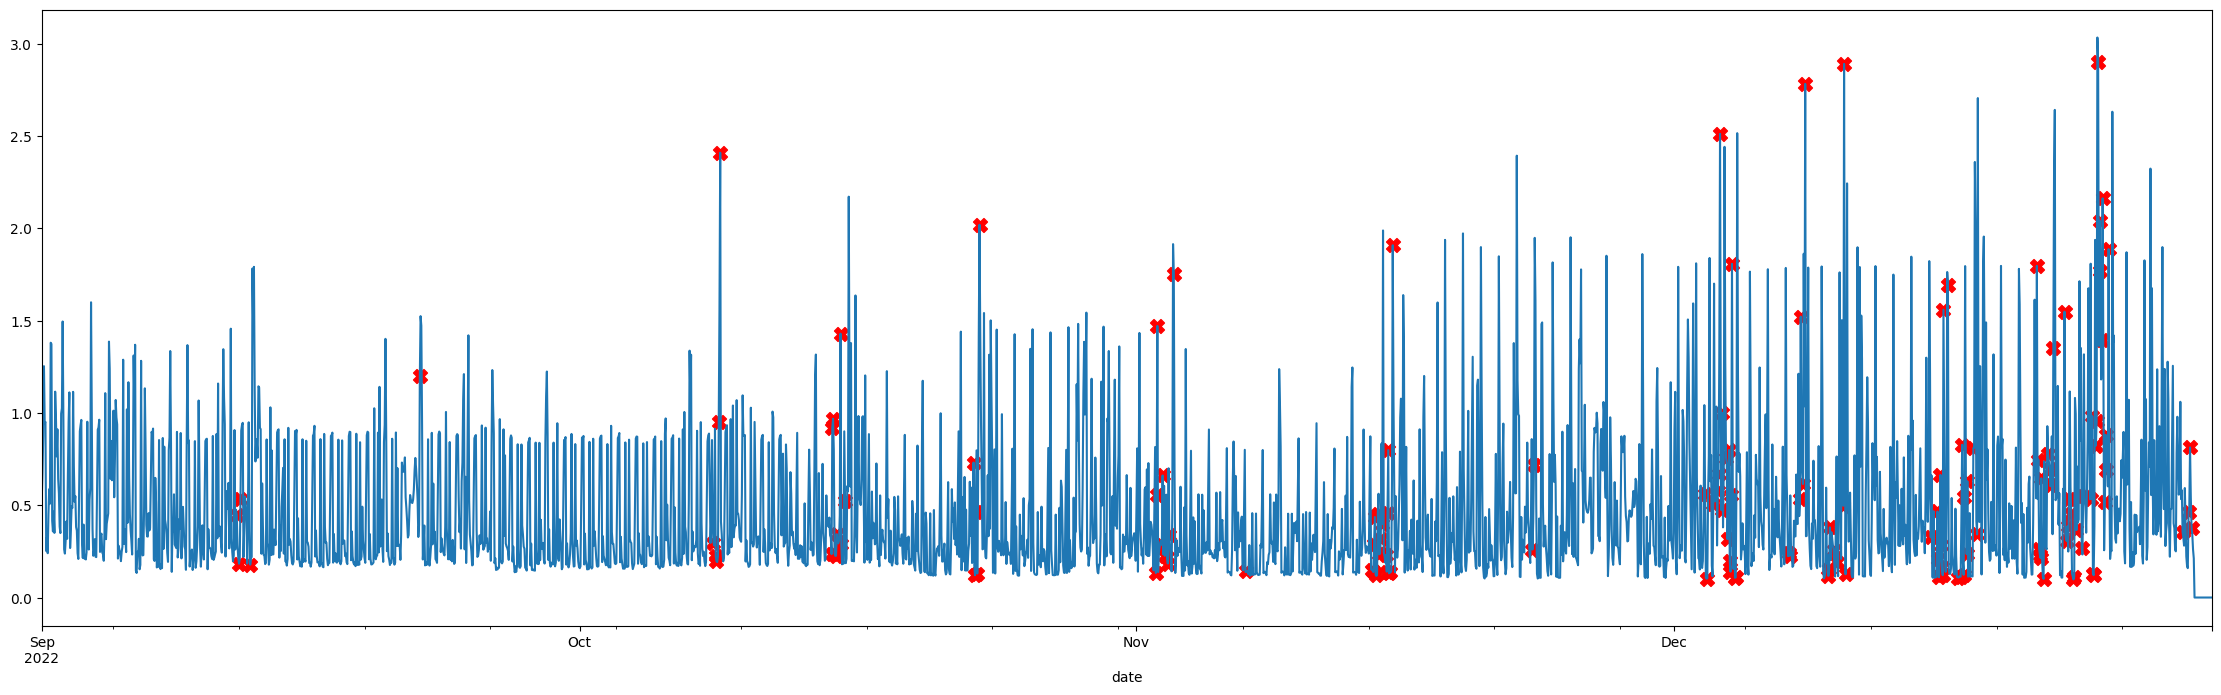

In [33]:
# Visualize the results
import matplotlib.pyplot as plt
ax = data.kw.plot(figsize=(28,8))
ax.scatter(x=potential_outliers.index.values, y=data.kw[potential_outliers.index], marker='X', c='r', s=100)

The Isolation Forest algorithm is generally **considered more interpretable than some other anomaly detection methods**, such as neural networks, because it is based on a simple and intuitive concept of isolating anomalies from the rest of the data. However, the algorithm is still not as transparent or easily explainable as some other machine learning algorithms, such as linear regression or decision trees.

One of the challenges with explaining Isolation Forest is that it is an ensemble method, meaning that it combines the results of multiple trees to generate a final anomaly score for each data point. The contribution of each tree to the final score may not be immediately obvious, making it difficult to understand how the algorithm arrived at its decision.

To address this challenge, researchers have proposed various techniques for visualizing and interpreting Isolation Forest models. For example, one approach is to plot the feature importance values, which show how much each feature contributes to the isolation of anomalies. Another approach is to visualize the paths taken by the algorithm to isolate anomalies, which can provide insights into the structure of the data and the nature of the anomalies.

In general, while Isolation Forest is not a completely transparent or explainable algorithm, it is still possible to gain some insights into how it works and how it arrived at its decision through various visualization and interpretation techniques.

#### Autoencoder

Autoencoders are a type of neural network that can be used for anomaly detection. The basic idea is to **train the autoencoder on a dataset of normal data points and then use it to reconstruct new data points. When the autoencoder is presented with an anomaly, it may not be able to reconstruct it accurately, indicating that it is an outlier or anomaly**.

The anomaly detection process using autoencoders typically involves two steps: training and testing. During training, the autoencoder is trained on a dataset of normal data points, which are passed through the encoder to produce a lower-dimensional representation, and then passed through the decoder to reconstruct the original data. The objective is to minimize the reconstruction error between the input and the output, which encourages the autoencoder to learn a compressed representation of the normal data.

During testing, the autoencoder is presented with new data points, and the reconstruction error is calculated between the input and the output. **If the reconstruction error is above a certain threshold, the data point is classified as an anomaly.**

The **interpretability of autoencoders can be challenging**, as they are often used in a black-box manner, and it may be difficult to understand the underlying factors that contribute to the reconstruction error or the decision to classify a data point as an anomaly. However, techniques such as visualization of the encoded representations or feature importance analysis can provide some insights into the behavior of the autoencoder.

![./images/autoencoder.png](./images/autoencoder.png)

In [34]:
# define the percentage of data to use
n_train = int(len(X)*0.75)

# define the training and test sets
X_train = X.iloc[:n_train]
X_test = X.iloc[n_train:, :]

X_test.shape

(721, 48)

In [35]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

class AutoEncoder(Model):
    def __init__(self, output_units, code_size=8):
        """
        Parameters
        ----------
        output_units: int
        Number of output units

        code_size: int
        Number of units in bottle neck
        """
        super().__init__()
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
  
# configurations of model
model = AutoEncoder(output_units=X_test.shape[1], code_size=4)
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    X_train,
    X_train,
    verbose=1,
    epochs=20,
    batch_size=512,
    validation_data=(X_test, X_test)
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.1051 - mse: 84.1555 - val_loss: 2.0706 - val_mse: 83.8682
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0313 - mse: 83.5932 - val_loss: 1.9726 - val_mse: 82.7794
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9189 - mse: 82.3487 - val_loss: 1.8442 - val_mse: 81.2063
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7939 - mse: 80.8572 - val_loss: 1.7559 - val_mse: 80.2032
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7106 - mse: 79.9612 - val_loss: 1.6903 - val_mse: 79.6220
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6524 - mse: 79.4224 - val_loss: 1.6542 - val_mse: 79.2964
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6324 - mse: 79.2014 - val_loss: 1.6466 - val_mse: 79.2582
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6274 - mse: 79.1741 - val_loss: 1.6492 - val_mse: 79.2609
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6268 - mse: 7

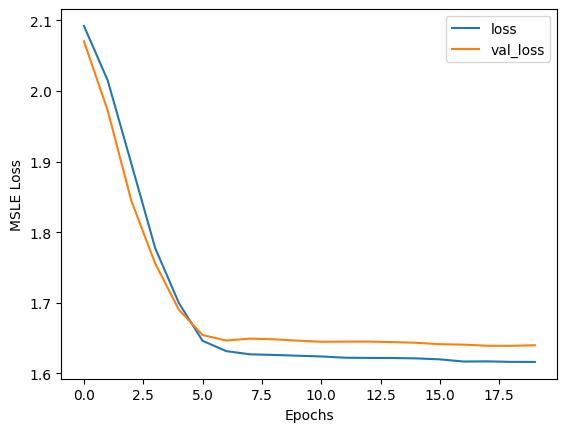

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

So, around 10-12 epoch should be enough. So, let us keep the 12 for this purpose.

In [37]:
history = model.fit(
    X_train,
    X_train,
    verbose=1,
    epochs=10,
    batch_size=512,
    validation_data=(X_test, X_test)
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6162 - mse: 79.1457 - val_loss: 1.6389 - val_mse: 79.2393
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6160 - mse: 79.1451 - val_loss: 1.6391 - val_mse: 79.2398
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6158 - mse: 79.1441 - val_loss: 1.6394 - val_mse: 79.2405
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6159 - mse: 79.1446 - val_loss: 1.6389 - val_mse: 79.2390
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6160 - mse: 79.1448 - val_loss: 1.6390 - val_mse: 79.2394
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6158 - mse: 79.1439 - val_loss: 1.6390 - val_mse: 79.2394
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6157 - mse: 79.1440 - val_loss: 1.6390 - val_mse: 79.2392
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6156 - mse: 79.1434 - val_loss: 1.6389 - val_mse: 79.2389
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6158 - mse: 79

The threshold is calculated as the mean of the reconstruction errors plus one standard deviation. This is a common technique for setting thresholds in anomaly detection algorithms.

In [38]:
import tensorflow as tf

def find_threshold(model, X_test):
  reconstructions = model.predict(X_test)

  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, X_test)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())

  return threshold

In [39]:
def get_predictions(model, X_test, threshold):
  predictions = model.predict(X_test)

  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, X_test)

  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold

  #preds = anomaly_mask.map(lambda x: False if x == True else 1.0)
  return anomaly_mask

threshold = find_threshold(model, X)
print(f"Threshold: {threshold}")

predictions = get_predictions(model, X, threshold)
predictions.tail()

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
Threshold: 1.6380886265951047
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


2877    True
2878    True
2879    True
2880    True
2881    True
dtype: bool

In [40]:
potential_anomalies = X[predictions.values]
potential_anomalies

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
date,,,,,,,,,,,,,,,,,,,,,
2022-09-12 23:00:00,0.183,0.0,0.212,1.0,0.534,2.0,0.904,3.0,0.934,4.0,...,1.465,19.0,1.791,20.0,1.123,21.0,0.737,22.0,0.858,23.0
2022-09-13 01:00:00,0.534,2.0,0.904,3.0,0.934,4.0,0.946,5.0,0.219,6.0,...,1.123,21.0,0.737,22.0,0.858,23.0,0.830,0.0,0.757,1.0
2022-09-13 02:00:00,0.904,3.0,0.934,4.0,0.946,5.0,0.219,6.0,0.380,7.0,...,0.737,22.0,0.858,23.0,0.830,0.0,0.757,1.0,1.144,2.0
2022-09-13 03:00:00,0.934,4.0,0.946,5.0,0.219,6.0,0.380,7.0,0.547,8.0,...,0.858,23.0,0.830,0.0,0.757,1.0,1.144,2.0,1.137,3.0
2022-09-13 04:00:00,0.946,5.0,0.219,6.0,0.380,7.0,0.547,8.0,0.506,9.0,...,0.830,0.0,0.757,1.0,1.144,2.0,1.137,3.0,0.919,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 20:00:00,0.379,21.0,0.343,22.0,0.260,23.0,0.212,0.0,0.000,1.0,...,0.000,16.0,0.000,17.0,0.000,18.0,0.000,19.0,0.000,20.0
2022-12-30 21:00:00,0.343,22.0,0.260,23.0,0.212,0.0,0.000,1.0,0.000,2.0,...,0.000,17.0,0.000,18.0,0.000,19.0,0.000,20.0,0.000,21.0
2022-12-30 22:00:00,0.260,23.0,0.212,0.0,0.000,1.0,0.000,2.0,0.000,3.0,...,0.000,18.0,0.000,19.0,0.000,20.0,0.000,21.0,0.000,22.0


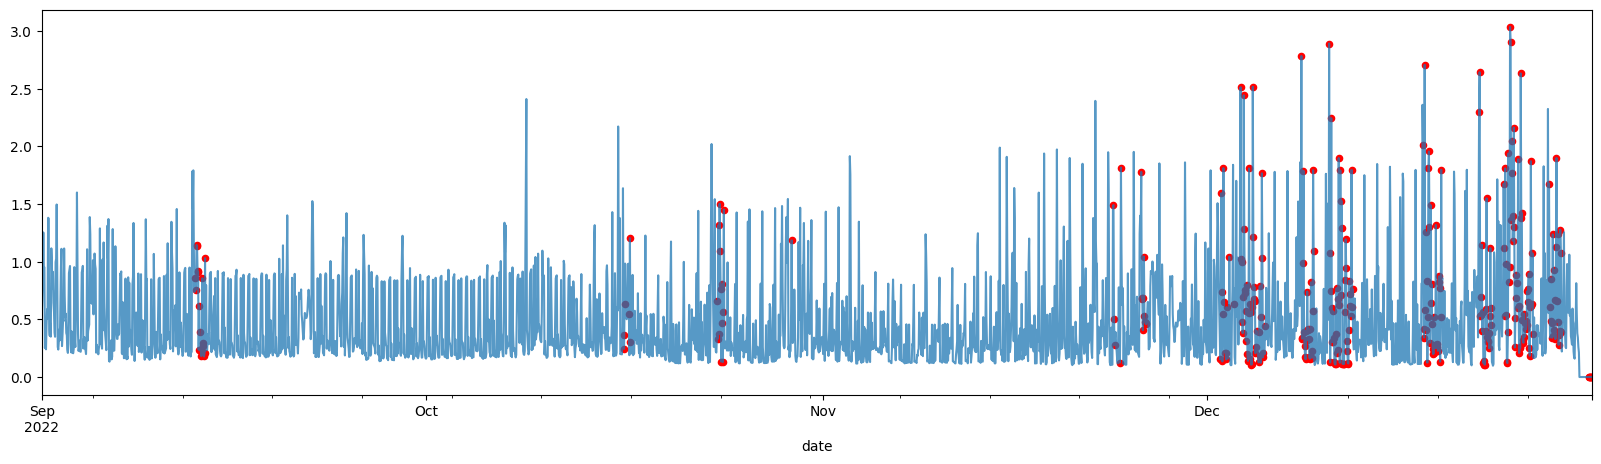

In [41]:
# Visualize the results
ax = data.kw.plot(figsize=(20,5), alpha=0.75)
_ = ax.scatter(x=potential_anomalies.index.values, 
               y=data.kw[potential_anomalies.index], 
               c='r', 
               s=20)
plt.show()

Interpretability might be a bit difficult but it is possible to see some change in the "local" behaviour of the consumption for some of the cases, which might indicate some kind of anomaly.

### Ensembles

Anomaly detection ensembles are a collection of multiple anomaly detection models that work together to identify anomalies in data. Ensembles are commonly used in anomaly detection because they can improve the overall accuracy and robustness of the detection process.

There are several types of anomaly detection ensembles, including:

- **Voting ensembles**: In a voting ensemble, each model in the ensemble independently analyzes the data and casts a vote for whether it is anomalous or not. The final decision is made based on the majority vote of the models.

- **Stacking ensembles**: In a stacking ensemble, the output of each model in the ensemble is used as input to a higher-level model, which combines their outputs to make a final decision.

- **Boosting ensembles**: In a boosting ensemble, models are trained sequentially, with each model trying to correct the errors made by the previous models.

- **Bagging ensembles**: In a bagging ensemble, multiple models are trained independently on different subsets of the data, and their outputs are combined to make a final decision.

Ensembles can be effective in anomaly detection because they can help reduce the risk of false positives or false negatives that can occur with single models. By combining the outputs of multiple models, ensembles can also help improve the overall accuracy of anomaly detection.
